### Jupyter notebook to perform the analysis and produce all figures in the paper entitled

# __There really is no ``Giant Arc"__

### by Till Sawala and Meri Teeriaho (2025)

#### This notebook includes all functions to reproduce the data and figures presented in the paper. It does not rely on any external data. You are free to use any part of this notebook with attribution (CC BY, https://creativecommons.org/licenses/by/4.0/), and if you use any part of it for scientific work, we ask that you cite the corresponding paper (you should also cite the papers for the python packages such as scipy, where available). Please contact till.sawala@helsinki.fi with any questions.


## Imports

In [1]:
import sys
import numpy as np
import pickle
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.colors as cm
import itertools
from tqdm import tqdm
import h5py
import os
import math
from scipy.spatial import ConvexHull, Delaunay
from mst_clustering import MSTClustering
from joblib import Parallel, delayed
from sklearn import cluster 
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import normalize
from spam.excursions import simulateRandomField
import matplotlib.pyplot as plt
from scipy.ndimage import zoom

# In case some non-standard packages aren't available, they can be installed like this:
#    !{sys.executable} -m pip install --user py-sphviewer
#    !{sys.executable} -m pip install --user mst_clustering
#    !{sys.executable} -m pip install --user spam

print ("Imports completed")

Imports completed


## Set some global parameters.

In [2]:
DEFAULT_DENSITY = 504 / (1541*1615*338) # This is the foreground density of Lopez et al. 2022

print ("default point density:", DEFAULT_DENSITY)

DEFAULT_SLICE_THICKNESS = 338. # thickness of the slice in Mp
DEFAULT_BOX_SIZE = 2800. # width of the slice
DEFAULT_N_PER_SLICE = int (np.round(DEFAULT_DENSITY * DEFAULT_SLICE_THICKNESS * DEFAULT_BOX_SIZE**2))

print ("default N:", DEFAULT_N_PER_SLICE) # Number of points per slice

DEFAULT_LINKING_LENGTH = 95.
DEFAULT_N_MIN = 6 # require at least these many points per FoF group (the GA has ~40)

# Covariance length scales used (in cMpc)
len_scales = [0, 50, 100, 200, 300, 400]

# For the parallelisation of the group finding.
N_jobs = 10

# How many realisations of the background?
N_BG = 1000

# How many foreground samples for each background?
N_rand = 100

# For the paper, we use N_BG = 1000 and N_rand = 100, i.e. we construct 1000 independent backgrounds
# and sample each one with 100 independent foregrounds. However, this takes several hours to compute.
# To quickly test the code with nearly identical results, we suggest something linke N_BG = 10 and N_rand = 10.

# Determine the resolution of the background density.
N_cells = 200 
N_zoom = 20

N_Quasars = 28960 # Total number of quasars in the background, calculated from the mean density and cell size given by Lopez & Clowes (2025)

# Make directory for plots and intermediate results
results_dir = "results/"
plots_dir = "figures/"
os.makedirs(plots_dir, exist_ok=True) 
os.makedirs(results_dir, exist_ok=True) 

default point density: 5.991542865916867e-07
default N: 1588


## Functions and classes

### Helper functions to compute properties of groups

In [3]:
def distances_3D(segments):

    '''
    Compute the lengths of the segments of the MST
    '''
    
    x_dis = segments[0]
    y_dis = segments[1]
    z_dis = segments[2]

    dis = []
    for i in range(len(x_dis[0])):
        p1 = [x_dis[0][i], y_dis[0][i], z_dis[0][i]]
        p2 = [x_dis[1][i], y_dis[1][i], z_dis[1][i]]
        dis.append(math.dist(p1, p2))
    return dis

def mean_dist(cluster, linklen, min_size):

    '''
    Compute the MST of a group, return the overdensity and the hull volume
    '''
    
    sub_alg = MSTClustering(cutoff_scale=linklen, min_cluster_size=min_size)
    sub_labels = sub_alg.fit_predict(cluster)
    segments = sub_alg.get_graph_segments(full_graph=True)
 
    dis_3D = distances_3D(segments)
    mean_dist = np.mean(dis_3D)

    return mean_dist
 
def create_sphere_points(center, radius, num_points=100):
    
    '''
    Expand a point into a sphere, used in computing the convex hull
    '''
    
    # Generate uniform random points on a sphere
    phi = np.random.uniform(0, 2 * np.pi, num_points)  # Azimuthal angle
    cos_theta = np.random.uniform(-1, 1, num_points)   # Cosine of polar angle
    theta = np.arccos(cos_theta)                        # Polar angle

    # Convert spherical coordinates to Cartesian coordinates
    x = center[0] + radius * np.sin(theta) * np.cos(phi)
    y = center[1] + radius * np.sin(theta) * np.sin(phi)
    z = center[2] + radius * np.cos(theta)

    return np.vstack((x, y, z)).T

def hull_and_points(cluster_points, mean_dist):
    
    '''
    Return the convex hull object and the set of points that define it.
    '''
    
    radius = mean_dist / 2

    expanded_points = []
    for point in cluster_points:
        points = create_sphere_points(point, radius)    
        expanded_points.append(points)

    expanded_points = np.vstack(expanded_points)
    hull = ConvexHull(expanded_points)

    return hull, expanded_points

def eigen(data):

    '''
    Function to compute the eigenvectors and eigenvalues.
    Returns eigenvectors and eigenvalues in descending order of the eigenvalues.
    '''
    
    covariance = np.cov(data.T)
    eigenvalues, eigenvectors = np.linalg.eigh(covariance)
    idx_sorted = eigenvalues.argsort()[::-1]                      
    eigenvalues = eigenvalues[idx_sorted]
    eigenvectors = eigenvectors[:,idx_sorted]
    return np.sqrt(eigenvalues), eigenvectors


### Define the __Mygroup__ class that holds the basic properties of an identified cluster, as well as methods to calculate additional properties

In [4]:
class MyGroup:
    
    '''
    A class to contain all the information about a group. The overdensities are computed only after a call.
    '''
    
    def __init__(self, coords, background, linking_length):    # if a group is created from a set of points

        self.center = np.mean(coords, axis = 0)
        self.coords = coords 
        self.background = background
        self.linking_length = linking_length

        self.eigenvalues, self.eigenvectors =  eigen(coords)

        sqdistances = pairwise_distances(self.coords, metric='sqeuclidean', n_jobs=1, force_all_finite=True)
        self.extent = np.max(sqdistances)**.5
        
        self.ba = self.eigenvalues[1] / self.eigenvalues[0]

        self.M = len(self.coords)
        self.N = len(self.background)
    
    def point_overdensity(self):
    
        '''
        Method to compute the points overdensity, defined by the group members and the hull volume.
        We don't show this in the present paper, but it is presented here: https://arxiv.org/abs/2502.03515
        '''

        mean_distance = mean_dist(self.coords,self.linking_length, self.M)
        
        hull, expanded_points = hull_and_points(self.coords, mean_distance)
        hullvolume= hull.volume

        density = self.M / hullvolume
        overdensity  = (density - DEFAULT_DENSITY) / DEFAULT_DENSITY
        
        return overdensity

### Functions for computing 

In [5]:
def find_groups(data, M, linking_length):

    '''
    Function to find and return the groups in the data above some threshold count.
    This will be called in parallel. This function is agnostic to the orientation of the slice.
    '''

    Groups = [] # list of groups to be returned.
    
    single_linkage = cluster.AgglomerativeClustering(
            n_clusters=None,
            linkage="single",
            metric="euclidean",
            distance_threshold=linking_length)

    single_linkage.fit(data)
    y_pred = single_linkage.labels_.astype(int)
    values, counts = np.unique(y_pred, return_counts=True)
        
    idx = np.where(counts > M)[0]

    N_groups = len(idx)
        
    for i in range (N_groups):

        members = np.where(y_pred == values[idx[i]])[0]
        group_coords = data[members,:]

        # we have found a valid group, now let's create a group class instance.
                
        ThisGroup = MyGroup(coords=group_coords, background=data, linking_length = linking_length)
        Groups.append(ThisGroup)

    return Groups

## Plotting Functions

### Plot the background densities *(Figure 1)*

We will create one sample each of the background and plot it, using the information about the average scatter $\sigma_{65}$ computed from the full sample.


In [6]:
def plot_background(N_BG = 2):
    
    # we will sample on a discrete mesh, with a 0.5 cMpc resolution
    coords = DEFAULT_BOX_SIZE / (N_cells*N_zoom - 1) * np.arange(N_cells*N_zoom)

    # Read the computed sigma_65 values 
    sigma_65 = np.load(results_dir+'/sigma_65_N_BG'+str(int(N_BG))+'_N_rand'+str(int(N_rand))+'.npy', allow_pickle=True)
    
    for i_cov, len_cov in enumerate(len_scales):
     
        covarianceParameters = {"len_scale": len_cov / DEFAULT_BOX_SIZE}

        # With the default values, we generate at a resolution of 14 Mpc (2800 / N_cells) and interpolate.
        # This is appropriate, because the covariance length is always larger than this.

        if len_cov > 0:
        
            GaussianRandomField = np.array(simulateRandomField(nNodes=N_cells, covarianceModel="Gaussian", covarianceParameters=covarianceParameters, dim=2, nRea=1)[0])

        else:
            GaussianRandomField = np.ones( (N_cells, N_cells) )
        
        GaussianRandomField = zoom(GaussianRandomField, N_zoom) # Enlarge and interpolate
        
        # Renormalise the field so it has a minimum of 0 and a sum of 1, so it can be used as a probability density map.
        GaussianRandomField = GaussianRandomField + np.abs(np.min(GaussianRandomField))
        GaussianRandomField = GaussianRandomField / np.sum(GaussianRandomField)

        print ("mean value:", np.mean(GaussianRandomField) * N_Quasars / DEFAULT_BOX_SIZE**2 * (N_cells*N_zoom)**2 )
        print ("max value:", np.max(GaussianRandomField) * N_Quasars / DEFAULT_BOX_SIZE**2 * (N_cells*N_zoom)**2 )
        print ("mean quasar number per square:", np.mean(GaussianRandomField) * N_Quasars / DEFAULT_BOX_SIZE**2 * (N_cells*N_zoom)**2 * 65**2 )

        # For the plotting, we scale this to number of quasars per cMpc**2.
        GaussianRandomField = GaussianRandomField * N_Quasars / DEFAULT_BOX_SIZE**2 * (N_cells*N_zoom)**2

        vmin = 0
        vmax = 0.008 # use the same scale on all panels
        
        # Now the plot
        fig = plt.figure(figsize=(8/2.54, 8/2.54))
        gs = GridSpec(1, 1, hspace=0.05,wspace=0.5, bottom=0.15, left=0.2, right=0.72)         
        ax = fig.add_subplot(gs[0])
        ax.set_aspect(1)
        im = ax.imshow(GaussianRandomField, vmin=0, vmax=vmax)
    
        ax.text(0.5,0.93, r'$\mathrm{L_{cov}} = '+str(int(len_cov))+'\ c\mathrm{Mpc} \ \ \ \ \sigma_\mathrm{65} = $'
                +str(np.round(sigma_65[i_cov], 2)), 
                color = 'white', horizontalalignment='center', fontsize = 8, transform=ax.transAxes )
    
        ax.set_xlabel(r'$x\ [c \mathrm{Mpc]}$')
        ax.set_ylabel(r'$y\ [c \mathrm{Mpc]}$')
        ax.set_xticks([0,1000,2000,3000,4000])
        ax.set_xticklabels([0,700,1400,2100,2800])
        ax.set_yticks([0,1000,2000,3000,4000])
        ax.set_yticklabels([0,700,1400,2100,2800])

        # Color bar
         
        cax = fig.add_axes([ax.get_position().x1+.05 , ax.get_position().y0, 0.05, ax.get_position().height])
        cbar = fig.colorbar(im, cax=cax)

        cbar.ax.set_ylabel(r'$\mathrm{\Sigma_q}\ [c\mathrm{Mpc^{-2}}]$')
    
        plt.savefig(plots_dir + '/background_lcov_'+str(int(len_cov))+'_N_BG'+str(N_BG)+'.pdf', dpi=200)
    

### Plot the CDF and PDF for the length of the longest group in individual samples of individual slices.  *(Figure 2)*

In [21]:
def plot_len_pdf_cdf_inhomogeneous(N_BG = 2, N_rand = 2):
    fig, ax = plt.subplots(1,2, figsize=(15/2.54, 6/2.54))

    # inset axes
    
    left, bottom, width, height = [0.84, 0.34, 0.13, 0.59]
    ax2 = fig.add_axes([left, bottom, width, height])
    ax2.set_xlim([739,745])
    ax2.set_xticks([740,742,744])
    ax2.set_yticks([0.2,0.22, 0.24, 0.26])

    ax2.set_ylim([0.2,0.26])

    colors = [plt.cm.viridis(0.), plt.cm.viridis(0.25), plt.cm.viridis(0.4), plt.cm.viridis(0.55), plt.cm.viridis(0.8), plt.cm.viridis(0.95)]

    for i, len_cov in enumerate(len_scales):

        lengths = np.load(results_dir+'/lengths_for_slices_shotnoise_inhomogeneous_lcov_'+str(int(len_cov))+
                          '_scaleN_BG'+str(int(N_BG))+'_N_rand'+str(int(N_rand))+'.npy', allow_pickle=True)
       
        # Compute and plot empirical PDF
        counts, bins = np.histogram(lengths, bins=30, range = (200, 1500), density=True)
        bin_centers = (bins[:-1] + bins[1:]) / 2        
        ax[0].plot(bin_centers, counts, lw = 2, alpha=1, label=r'$\mathrm{L_{cov}} = $'+str(len_cov)+r' $c$Mpc', color = colors[i])

        # Compute and plot empirical CDF
        counts, bins = np.histogram(lengths, bins=10000, range = (200, 1500), density=True)
        cdf = 1 - np.cumsum(counts * np.diff(bins))  # CDF

        
        ax[1].plot(bins[:-1], cdf, lw = 2, alpha=1, label=r'$\mathrm{L_{cov}} = $'+str(len_cov)+r' $c$Mpc', color = colors[i])
        ax2.plot(bins[:-1], cdf, lw = 1, alpha=1, label=r'$\mathrm{L_{cov}} = $'+str(len_cov)+r' $c$Mpc', color = colors[i])

    # Plot a vertical line at the length of the GA.

    ax[0].axvline(742, color='grey', alpha=0.7, ls = 'dotted')
    ax[1].axvline(742, color='grey', alpha=0.7, ls = 'dotted')
    ax2.axvline(742, color='grey', alpha=0.7, ls = 'dotted')
        
    # Annotations
    ax[0].set_ylabel(r'$\mathrm{PDF~[}c\mathrm{Mpc^{-1}]}$')

    ax[0].legend(loc="upper right", frameon=False)
    ax[1].set_ylabel(r'$\mathrm{CDF}$')
    
    ax[0].set_xlabel(r'$\mathrm{L_{max}~[}c\mathrm{Mpc]}$')
    ax[1].set_xlabel(r'$\mathrm{L_{max}~[}c\mathrm{Mpc]}$')

    ax[0].text(810,0.5*0.004, r'"Giant Arc"',  horizontalalignment='center', color = 'white', rotation='vertical')
    ax[1].text(810,0.3, r'"Giant Arc"',  horizontalalignment='center', color = 'white', rotation='vertical')
    
    y_lims = [0, 0.003] 
    ax[0].set_ylim(y_lims)

    y_lims = [0, 1] 
    ax[1].set_ylim(y_lims)
    
    x_lims = [200, 1500]    
    ax[0].set_xlim(x_lims)
    ax[1].set_xlim(x_lims)

    ax[0].set_yticks([0.0, 0.001, 0.002, 0.003])
    
    plt.subplots_adjust(bottom=0.15, right=0.99, top=0.97, wspace=0.3)
    plt.savefig(plots_dir +'len_histogram_pdf_cdf_shotnoise_inhomogeneous'+str(int(N_BG))+'_N_rand'+str(int(N_rand))+'.pdf', dpi=200)

## Functions for computing

In [22]:
def compute_len_histogram_shotnoise_background(N_BG = 10, N_rand = 10):
    
    lengths = []
    max_ba = 0.4

    N_elements = N_cells**2 * N_zoom**2 # Total number of elements

    # we will sample on a discrete mesh, with a 0.5 cMpc resolution
    coords = DEFAULT_BOX_SIZE / (N_cells*N_zoom - 1) * np.arange(N_cells*N_zoom)

    print ("min / max coords", min (coords), " / ", max(coords))
    print ("coords:", coords[0:10])

    sigma_65 = [] # list of average sigma_65 values
    
    for len_cov in len_scales :
     
        covarianceParameters = {"len_scale": len_cov / DEFAULT_BOX_SIZE}

        sigma_hist = []
    
        for i_BG in tqdm(range (N_BG)):

            # With the default values, we generate at a resolution of 14 Mpc (2800 / N_cells) and interpolate.
            # This is appropriate, because the covariance length is always larger than this.

            if len_cov > 0:
            
                GaussianRandomField = np.array(simulateRandomField(nNodes=N_cells, covarianceModel="Gaussian", covarianceParameters=covarianceParameters, dim=2, nRea=1)[0])

            else:
                GaussianRandomField = np.ones((N_cells, N_cells)) # With len_cov = 0, we simply create a uniform field.
            
            GaussianRandomField = zoom(GaussianRandomField, N_zoom) # Enlarge and interpolate
            
            # Renormalise the field so it has a minimum of 0 and a sum of 1, so it can be used as a probability density map.

            GaussianRandomField = GaussianRandomField + np.abs(np.min(GaussianRandomField))
            GaussianRandomField = GaussianRandomField / np.sum(GaussianRandomField)
    
            Gaussian_sequence = GaussianRandomField.flatten() # create a 1D array as weights for the random choice function.
    
            indices_1D = np.arange(N_elements)
            indices_2D = np.reshape(indices_1D, (N_cells * N_zoom, N_cells * N_zoom))
    
            # draw a sample of background quasars and compute the mean number and dispersion in 65 Mpc cells.
    
            xy=np.random.choice(indices_2D.flatten(), size=N_Quasars, p=Gaussian_sequence) # this sample size corresponds to 15.6 in 65x65 cMpc**2
    
            indices = np.unravel_index(xy, indices_2D.shape)
            
            x_random = coords[indices[0]]
            y_random = coords[indices[1]]

            # Now, bin the data in bins of 65**2 Mpc**2 and count the standard deviation.
            
            xedges = np.arange(0,2800, 65)
            yedges = np.arange(0,2800, 65)
    
            hist, xedges, yedges = np.histogram2d(x_random, y_random, bins = [xedges, yedges])

            sigma_hist.append(np.std(hist))
            
            # Now, draw one or more shot-noise point samples from this field and look for groups.
            # First, all the samples are generated, and then the group finding is done in parallel.
            
            data = []
            Groups = []
        
            for i_rand in range (N_rand):
        
                xy=np.random.choice(indices_2D.flatten(), size = DEFAULT_N_PER_SLICE, p=Gaussian_sequence, )
                indices = np.unravel_index(xy, indices_2D.shape)
            
                x_random = coords[indices[0]]
                y_random = coords[indices[1]]
                z_random = np.random.uniform(0, DEFAULT_SLICE_THICKNESS, DEFAULT_N_PER_SLICE)

                data.append(np.vstack((x_random, y_random, z_random)).T)
                     
            TheseGroups = Parallel(n_jobs=N_jobs)(
                delayed(find_groups)(data[i], DEFAULT_N_MIN, DEFAULT_LINKING_LENGTH) for i in range(len(data))
            )
            TheseGroups = list(TheseGroups)

            # Now, look for the longest anisotropic group within each shot-noise sample, and gather its length into the lengths list.

            for i_rand in range (N_rand):
                Groups = []
                
                for i, ThisGroup in enumerate (TheseGroups[i_rand]):
        
                    if ThisGroup.ba < max_ba:
                       Groups.append(ThisGroup)
         
                extents = [j.extent for j in Groups]
                if len(extents) != 0:
                    lengths.append(max(extents))

        sigma_65.append(np.mean(sigma_hist))
                    
        np.save(results_dir+'/lengths_for_slices_shotnoise_inhomogeneous_lcov_'+str(int(len_cov))+'_scaleN_BG'+str(int(N_BG))+'_N_rand'+str(int(N_rand))+'.npy', np.array(lengths))   

    np.save(results_dir+'/sigma_65_N_BG'+str(int(N_BG))+'_N_rand'+str(int(N_rand))+'.npy', np.array(sigma_65))

print('done')

done


### Perform the computations.

In [9]:
#compute_len_histogram_shotnoise_background(N_BG = N_BG, N_rand = N_rand)

### Plot Figure 1 (requires pre-computed data).

mean value: 0.0036938775510202853
max value: 0.0036938775510204085
mean quasar number per square: 15.606632653060705
Generating Field_0000... 1.44 seconds
mean value: 0.0036938775510204163
max value: 0.007093977885575728
mean quasar number per square: 15.60663265306126
Generating Field_0000... 1.36 seconds
mean value: 0.0036938775510204033
max value: 0.006966937656512104
mean quasar number per square: 15.606632653061205
Generating Field_0000... 1.30 seconds
mean value: 0.003693877551020414
max value: 0.007386633902273722
mean quasar number per square: 15.606632653061249
Generating Field_0000... 1.24 seconds
mean value: 0.0036938775510204106
max value: 0.006535740165607022
mean quasar number per square: 15.606632653061235
Generating Field_0000... 1.19 seconds
mean value: 0.0036938775510204085
max value: 0.0068295028783792715
mean quasar number per square: 15.606632653061226


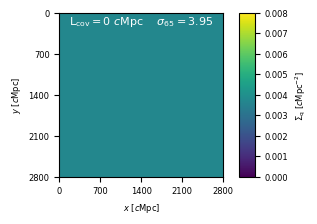

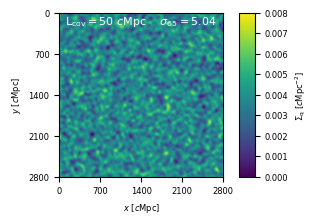

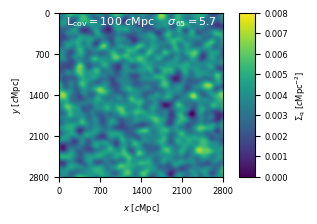

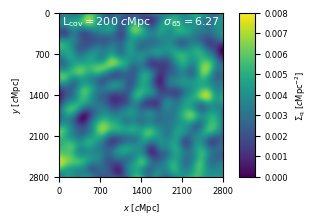

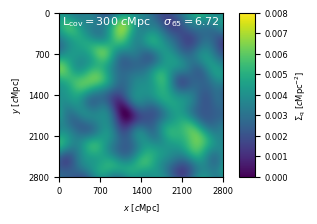

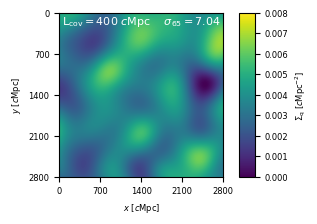

In [24]:
plot_background(N_BG = N_BG)

### Plot Figure 2 (requires pre-computed data).

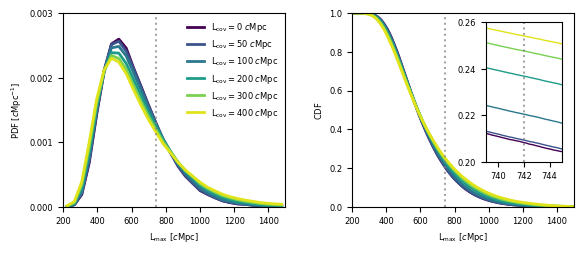

In [23]:
plot_len_pdf_cdf_inhomogeneous(N_BG = N_BG, N_rand = N_rand)